# over all


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "orders (1).csv"   # change if needed

def clean_currency(series: pd.Series) -> pd.Series:
    """
    Converts values like '$5,478.67' -> 5478.67
    Works even if the column is already numeric.
    """
    if series.dtype == "O":
        series = (
            series.astype(str)
            .str.replace("$", "", regex=False)
            .str.replace(",", "", regex=False)
            .str.strip()
        )
    return pd.to_numeric(series, errors="coerce")

# -------------------
# Load + clean
# -------------------
df = pd.read_csv(CSV_PATH)

needed_cols = ["Product name", "Copies", "Charged", "Charged amount"]
missing = [c for c in needed_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

df["Copies"] = pd.to_numeric(df["Copies"], errors="coerce").fillna(0)
df["Charged"] = df["Charged"].astype(str).str.strip().str.title()
df.loc[~df["Charged"].isin(["Yes", "No"]), "Charged"] = "Unknown"

df["Charged amount"] = clean_currency(df["Charged amount"])

# -------------------
# 1) Matrix/Table: Product totals
# -------------------
product_summary = (
    df.groupby("Product name", dropna=False)
      .agg(
          **{
              "Sum of Charged amount": ("Charged amount", "sum"),
              "Sum of Copies": ("Copies", "sum"),
          }
      )
      .sort_values("Sum of Charged amount", ascending=False)
)

# Add Total row like Power BI
total_row = pd.DataFrame(
    {
        "Sum of Charged amount": [product_summary["Sum of Charged amount"].sum()],
        "Sum of Copies": [product_summary["Sum of Copies"].sum()],
    },
    index=["Total"]
)
product_summary_with_total = pd.concat([product_summary, total_row])

print("\n=== POWER BI MATRIX (replica) ===")
print(product_summary_with_total.round(2))



=== POWER BI MATRIX (replica) ===
                     Sum of Charged amount  Sum of Copies
Large-Format Poster                5478.67           1484
3D Print                            686.80            232
Document                            178.91            606
Booklet                             177.73             58
Total                              6522.11           2380


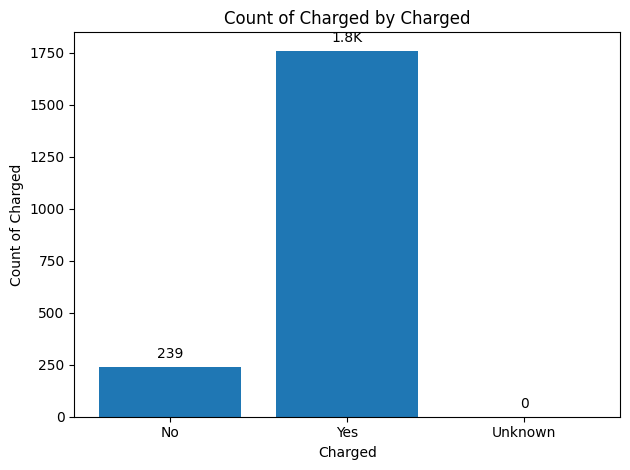

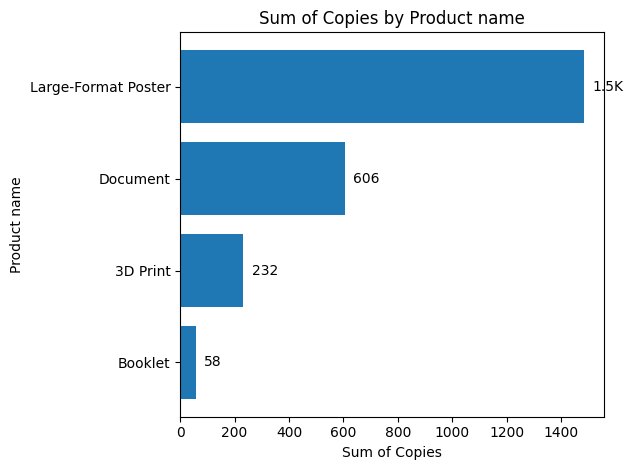

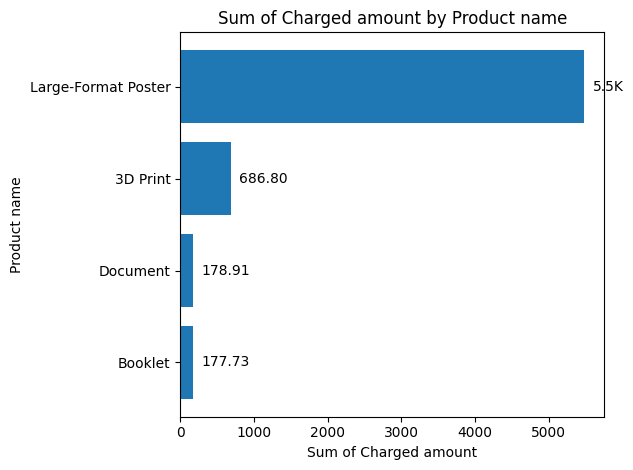

In [2]:
import matplotlib.pyplot as plt

def fmt_k(x):
    """Format numbers like Power BI labels: 232 -> 232, 1484 -> 1.5K, 5478.67 -> 5.5K"""
    try:
        x = float(x)
    except:
        return str(x)
    if abs(x) >= 1000:
        return f"{x/1000:.1f}K"
    # show integers without decimals, otherwise 2 decimals
    return f"{int(x)}" if x.is_integer() else f"{x:.2f}"

def label_bars_vertical(ax, labels=None):
    """Add labels on top of vertical bars."""
    for i, rect in enumerate(ax.patches):
        val = rect.get_height()
        text = labels[i] if labels is not None else fmt_k(val)
        ax.annotate(
            text,
            (rect.get_x() + rect.get_width()/2, rect.get_height()),
            ha="center", va="bottom",
            xytext=(0, 4), textcoords="offset points"
        )

def label_bars_horizontal(ax, labels=None):
    """Add labels at the end of horizontal bars."""
    for i, rect in enumerate(ax.patches):
        val = rect.get_width()
        text = labels[i] if labels is not None else fmt_k(val)
        ax.annotate(
            text,
            (rect.get_width(), rect.get_y() + rect.get_height()/2),
            ha="left", va="center",
            xytext=(6, 0), textcoords="offset points"
        )

# ---- Example usage on your 3 charts ----
# 1) Count of Charged by Charged (vertical bar)
fig, ax = plt.subplots()
ax.bar(count_charged.index, count_charged.values)
ax.set_title("Count of Charged by Charged")
ax.set_xlabel("Charged")
ax.set_ylabel("Count of Charged")

# If you want PowerBI-like labels (0.2K, 1.8K), use fmt_k
label_bars_vertical(ax)   # or: label_bars_vertical(ax, [fmt_k(v) for v in count_charged.values])

plt.tight_layout()
plt.show()

# 2) Sum of Copies by Product name (horizontal)
fig, ax = plt.subplots()
ax.barh(copies_by_product.index, copies_by_product.values)
ax.set_title("Sum of Copies by Product name")
ax.set_xlabel("Sum of Copies")
ax.set_ylabel("Product name")

label_bars_horizontal(ax)
plt.tight_layout()
plt.show()

# 3) Sum of Charged amount by Product name (horizontal)
fig, ax = plt.subplots()
ax.barh(amt_by_product.index, amt_by_product.values)
ax.set_title("Sum of Charged amount by Product name")
ax.set_xlabel("Sum of Charged amount")
ax.set_ylabel("Product name")

label_bars_horizontal(ax)
plt.tight_layout()
plt.show()


# 3d print

3D Print totals -> Copies: 232  Charged amount: 686.8

=== Material table (Power BI matrix replica) ===
                Sum of Copies  Sum of Charged amount
PLA                       186                 548.36
PetG                       27                 109.75
TPU (Flexible)             19                  28.69
Total                     232                 686.80


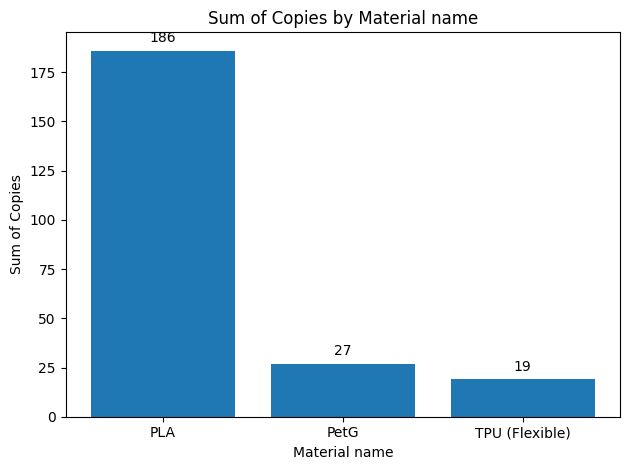

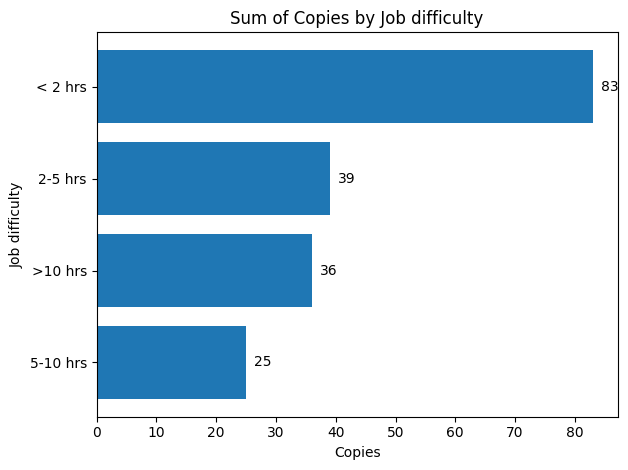

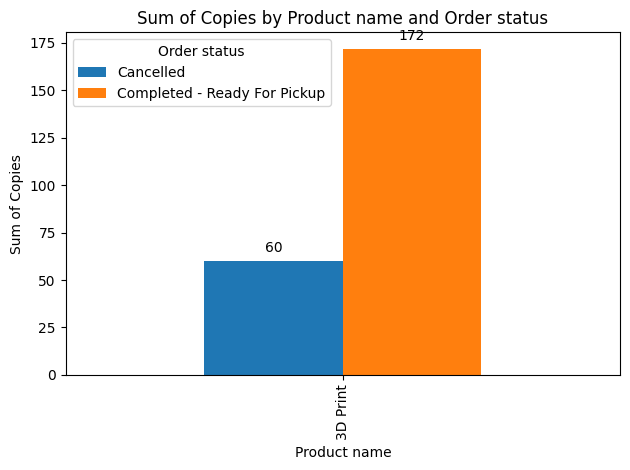

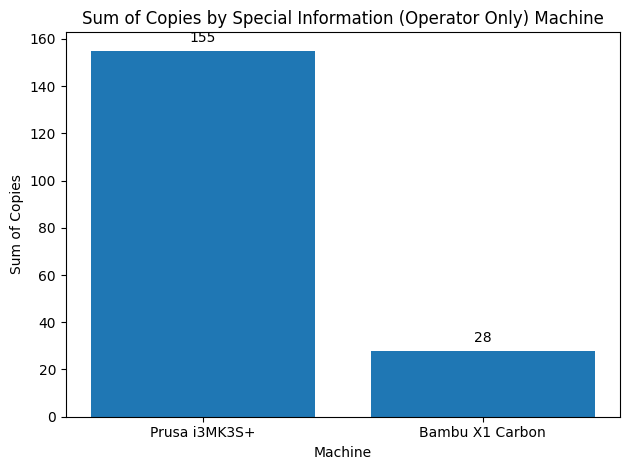

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "orders (1).csv"   # <-- change path if needed

# ---------- helpers ----------
def clean_currency(series: pd.Series) -> pd.Series:
    # '$5,478.67' -> 5478.67
    s = series.astype(str).str.replace("$", "", regex=False).str.replace(",", "", regex=False).str.strip()
    return pd.to_numeric(s, errors="coerce")

def fmt_k(x):
    # PowerBI-like labels: 172 -> 172, 1484 -> 1.5K
    x = float(x)
    if abs(x) >= 1000:
        return f"{x/1000:.1f}K"
    return f"{int(x)}" if x.is_integer() else f"{x:.2f}"

def label_bars_vertical(ax):
    for rect in ax.patches:
        val = rect.get_height()
        ax.annotate(
            fmt_k(val),
            (rect.get_x() + rect.get_width()/2, val),
            ha="center", va="bottom",
            xytext=(0, 4), textcoords="offset points"
        )

def label_bars_horizontal(ax):
    for rect in ax.patches:
        val = rect.get_width()
        ax.annotate(
            fmt_k(val),
            (val, rect.get_y() + rect.get_height()/2),
            ha="left", va="center",
            xytext=(6, 0), textcoords="offset points"
        )

# ---------- load + clean ----------
df = pd.read_csv(CSV_PATH)

# numeric
df["Copies"] = pd.to_numeric(df["Copies"], errors="coerce").fillna(0)
df["Charged amount"] = clean_currency(df["Charged amount"]).fillna(0)

# filter to 3D Print page
df3 = df[df["Product name"].astype(str).str.strip() == "3D Print"].copy()

# quick check (matches your screenshot)
total_copies = df3["Copies"].sum()
total_amt = df3["Charged amount"].sum()
print("3D Print totals -> Copies:", int(total_copies), " Charged amount:", round(total_amt, 2))

# ---------- 1) Matrix/Table: Material name, Sum Copies, Sum Charged amount ----------
material_tbl = (
    df3.groupby("Material name", dropna=False)
       .agg(**{"Sum of Copies": ("Copies", "sum"),
               "Sum of Charged amount": ("Charged amount", "sum")})
       .sort_values("Sum of Copies", ascending=False)
)

total_row = pd.DataFrame(
    {"Sum of Copies": [material_tbl["Sum of Copies"].sum()],
     "Sum of Charged amount": [material_tbl["Sum of Charged amount"].sum()]},
    index=["Total"]
)
material_tbl2 = pd.concat([material_tbl, total_row])

print("\n=== Material table (Power BI matrix replica) ===")
print(material_tbl2.round(2))

# ---------- 2) Chart: Sum of Copies by Material name ----------
mat_chart = material_tbl.copy()
mat_chart = mat_chart[mat_chart.index.notna()]  # remove NaN label if any

fig, ax = plt.subplots()
ax.bar(mat_chart.index.astype(str), mat_chart["Sum of Copies"].values)
ax.set_title("Sum of Copies by Material name")
ax.set_xlabel("Material name")
ax.set_ylabel("Sum of Copies")
label_bars_vertical(ax)
plt.tight_layout()
plt.show()

# ---------- 3) Chart: Sum of Copies by Job difficulty (Operator Only) ----------
job_col = "Special Information (Operator Only) Job difficulty"
job_df = df3[df3[job_col].notna() & (df3[job_col].astype(str).str.strip() != "")]
job_sum = (
    job_df.groupby(job_col)["Copies"]
          .sum()
          .sort_values(ascending=False)
)

fig, ax = plt.subplots()
ax.barh(job_sum.index.astype(str), job_sum.values)
ax.set_title("Sum of Copies by Job difficulty")
ax.set_xlabel("Copies")
ax.set_ylabel("Job difficulty")
ax.invert_yaxis()  # biggest on top (like Power BI)
label_bars_horizontal(ax)
plt.tight_layout()
plt.show()

# ---------- 4) Chart: Sum of Copies by Product name and Order status ----------
status_sum = (
    df3.groupby(["Product name", "Order status"])["Copies"]
       .sum()
       .reset_index()
)

# Keep your screenshot-like order if present
preferred_status = ["Cancelled", "Completed - Ready For Pickup"]
present = [s for s in preferred_status if s in status_sum["Order status"].unique()]
others = [s for s in status_sum["Order status"].unique() if s not in present]
status_order = present + sorted(others)

pivot = (
    status_sum.pivot(index="Product name", columns="Order status", values="Copies")
              .fillna(0)
              .reindex(columns=status_order)
)

fig, ax = plt.subplots()
pivot.plot(kind="bar", ax=ax)  # clustered columns
ax.set_title("Sum of Copies by Product name and Order status")
ax.set_xlabel("Product name")
ax.set_ylabel("Sum of Copies")

# label each bar in clustered chart
for rect in ax.patches:
    val = rect.get_height()
    ax.annotate(fmt_k(val),
                (rect.get_x() + rect.get_width()/2, val),
                ha="center", va="bottom",
                xytext=(0, 4), textcoords="offset points")

plt.tight_layout()
plt.show()

# ---------- 5) Chart: Sum of Copies by Machine (Operator Only) ----------
machine_col = "Special Information (Operator Only) Machine"
machine_df = df3[df3[machine_col].notna() & (df3[machine_col].astype(str).str.strip() != "")]
machine_sum = (
    machine_df.groupby(machine_col)["Copies"]
              .sum()
              .sort_values(ascending=False)
)

fig, ax = plt.subplots()
ax.bar(machine_sum.index.astype(str), machine_sum.values)
ax.set_title("Sum of Copies by Special Information (Operator Only) Machine")
ax.set_xlabel("Machine")
ax.set_ylabel("Sum of Copies")
label_bars_vertical(ax)
plt.tight_layout()
plt.show()


# Document


DOCUMENT totals -> Copies: 606 Charged amount: 178.91

=== DOCUMENT TABLE ===
  Product name             Paper type         Paper size  Sum of Copies  \
0     Document              Cardstock  Letter (8.5 x 11)            172   
1     Document              Cardstock  Tabloid (11 x 17)             73   
2     Document  Generic Printer Paper  Letter (8.5 x 11)            239   
3     Document  Generic Printer Paper  Tabloid (11 x 17)            122   
4        Total                                                      606   

   Sum of Charged amount  
0                  29.23  
1                  35.84  
2                  76.30  
3                  37.54  
4                 178.91  


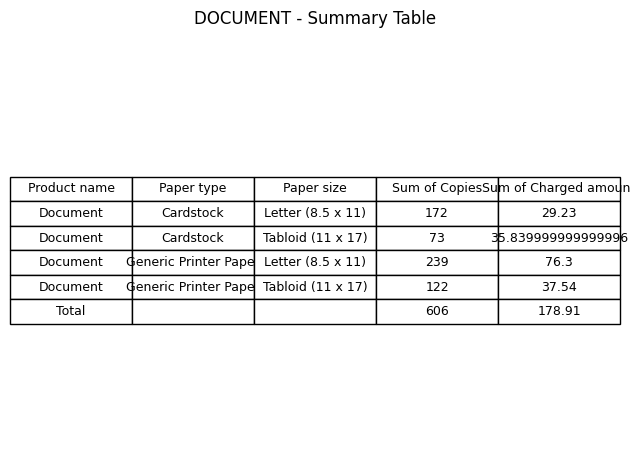

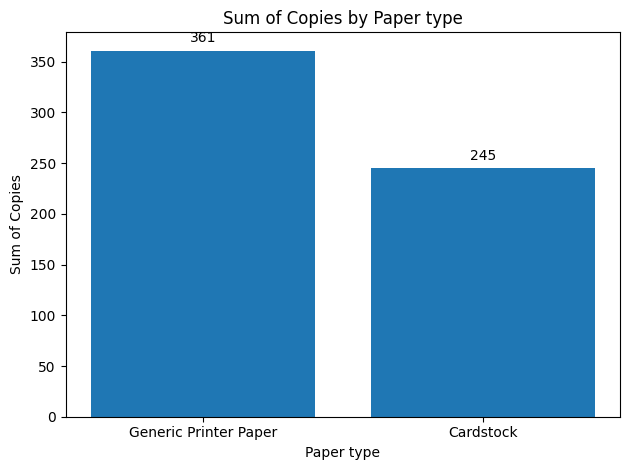

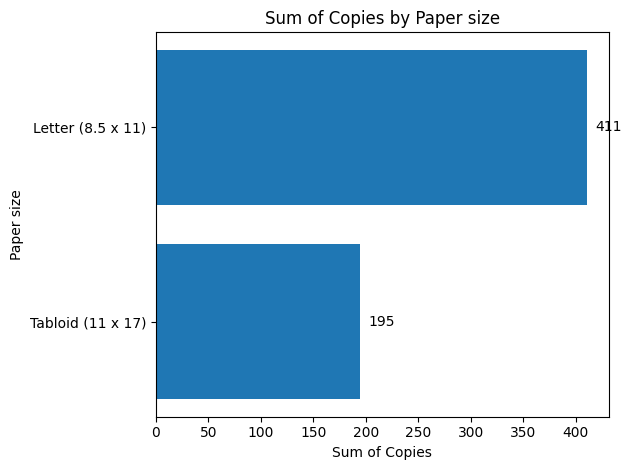

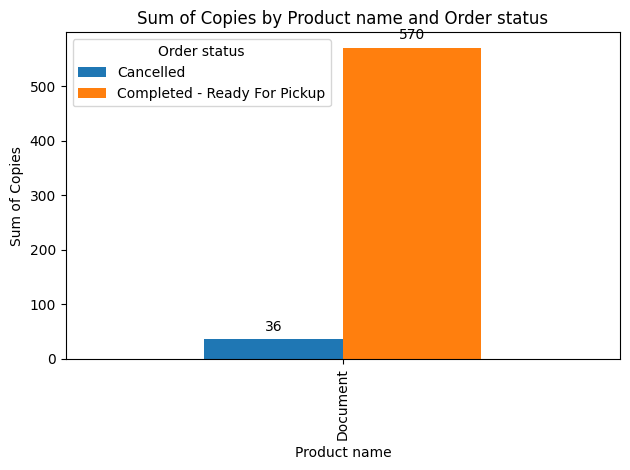

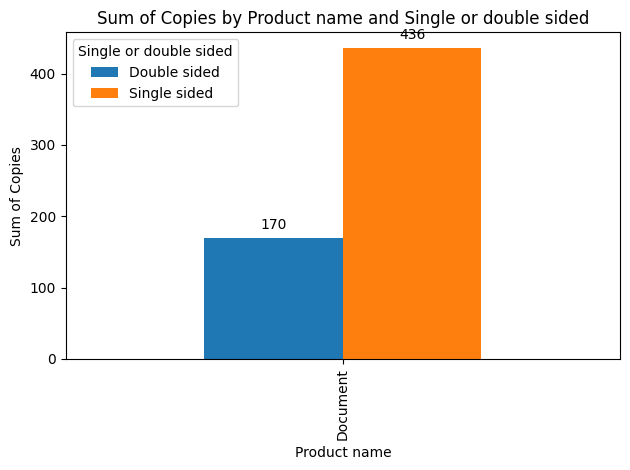

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "orders (1).csv"   # change if needed

# ---------------- helpers ----------------
def clean_currency(series: pd.Series) -> pd.Series:
    """Convert '$1,234.56' -> 1234.56 (works even if already numeric)."""
    if series.dtype == "O":
        s = (series.astype(str)
             .str.replace("$", "", regex=False)
             .str.replace(",", "", regex=False)
             .str.strip())
        return pd.to_numeric(s, errors="coerce")
    return pd.to_numeric(series, errors="coerce")

def label_bars_vertical(ax):
    for rect in ax.patches:
        val = rect.get_height()
        ax.annotate(
            f"{int(val)}",
            (rect.get_x() + rect.get_width()/2, val),
            ha="center", va="bottom",
            xytext=(0, 4), textcoords="offset points"
        )

def label_bars_horizontal(ax):
    for rect in ax.patches:
        val = rect.get_width()
        ax.annotate(
            f"{int(val)}",
            (val, rect.get_y() + rect.get_height()/2),
            ha="left", va="center",
            xytext=(6, 0), textcoords="offset points"
        )

# ---------------- load + clean ----------------
df = pd.read_csv(CSV_PATH)

needed = [
    "Product name", "Copies", "Charged amount",
    "Paper type", "Paper size", "Order status", "Single or double sided"
]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

df["Copies"] = pd.to_numeric(df["Copies"], errors="coerce").fillna(0)
df["Charged amount"] = clean_currency(df["Charged amount"]).fillna(0)

# Filter only DOCUMENT product
doc = df[df["Product name"].astype(str).str.strip() == "Document"].copy()

print("DOCUMENT totals -> Copies:", int(doc["Copies"].sum()),
      "Charged amount:", round(doc["Charged amount"].sum(), 2))

# ---------------- 1) Table (matrix replica) ----------------
tbl = (
    doc.groupby(["Product name", "Paper type", "Paper size"], dropna=False)
       .agg(**{"Sum of Copies": ("Copies", "sum"),
               "Sum of Charged amount": ("Charged amount", "sum")})
       .reset_index()
)

# Add Total row like Power BI
total_row = pd.DataFrame([{
    "Product name": "Total",
    "Paper type": "",
    "Paper size": "",
    "Sum of Copies": tbl["Sum of Copies"].sum(),
    "Sum of Charged amount": tbl["Sum of Charged amount"].sum()
}])
tbl_show = pd.concat([tbl, total_row], ignore_index=True)

print("\n=== DOCUMENT TABLE ===")
print(tbl_show)

# Optional: show the table as a figure (like Power BI visual)
fig, ax = plt.subplots()
ax.axis("off")
ax.set_title("DOCUMENT - Summary Table", pad=12)

table = ax.table(
    cellText=tbl_show.values,
    colLabels=tbl_show.columns,
    cellLoc="center",
    loc="center"
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.3)
plt.tight_layout()
plt.show()

# ---------------- 2) Sum of Copies by Paper type ----------------
paper_type_sum = doc.groupby("Paper type")["Copies"].sum().sort_values(ascending=False)

fig, ax = plt.subplots()
ax.bar(paper_type_sum.index.astype(str), paper_type_sum.values)
ax.set_title("Sum of Copies by Paper type")
ax.set_xlabel("Paper type")
ax.set_ylabel("Sum of Copies")
label_bars_vertical(ax)
plt.tight_layout()
plt.show()

# ---------------- 3) Sum of Copies by Paper size ----------------
paper_size_sum = doc.groupby("Paper size")["Copies"].sum().sort_values(ascending=False)

fig, ax = plt.subplots()
ax.barh(paper_size_sum.index.astype(str), paper_size_sum.values)
ax.set_title("Sum of Copies by Paper size")
ax.set_xlabel("Sum of Copies")
ax.set_ylabel("Paper size")
ax.invert_yaxis()  # biggest on top (like your screenshot)
label_bars_horizontal(ax)
plt.tight_layout()
plt.show()

# ---------------- 4) Sum of Copies by Product name and Order status ----------------
status_sum = (doc.groupby(["Product name", "Order status"])["Copies"].sum()
               .reset_index())

# Keep PowerBI-like legend order if present
preferred_status = ["Cancelled", "Completed - Ready For Pickup"]
status_cols = [s for s in preferred_status if s in status_sum["Order status"].unique()]
status_cols += [s for s in status_sum["Order status"].unique() if s not in status_cols]

pivot_status = (status_sum.pivot(index="Product name", columns="Order status", values="Copies")
                          .fillna(0)
                          .reindex(columns=status_cols))

fig, ax = plt.subplots()
pivot_status.plot(kind="bar", ax=ax)
ax.set_title("Sum of Copies by Product name and Order status")
ax.set_xlabel("Product name")
ax.set_ylabel("Sum of Copies")

for rect in ax.patches:
    val = rect.get_height()
    ax.annotate(f"{int(val)}",
                (rect.get_x() + rect.get_width()/2, val),
                ha="center", va="bottom",
                xytext=(0, 4), textcoords="offset points")

plt.tight_layout()
plt.show()

# ---------------- 5) Sum of Copies by Product name and Single/Double sided ----------------
sd_sum = (doc.groupby(["Product name", "Single or double sided"])["Copies"].sum()
            .reset_index())

preferred_sd = ["Double sided", "Single sided"]
sd_cols = [s for s in preferred_sd if s in sd_sum["Single or double sided"].unique()]
sd_cols += [s for s in sd_sum["Single or double sided"].unique() if s not in sd_cols]

pivot_sd = (sd_sum.pivot(index="Product name", columns="Single or double sided", values="Copies")
                 .fillna(0)
                 .reindex(columns=sd_cols))

fig, ax = plt.subplots()
pivot_sd.plot(kind="bar", ax=ax)
ax.set_title("Sum of Copies by Product name and Single or double sided")
ax.set_xlabel("Product name")
ax.set_ylabel("Sum of Copies")

for rect in ax.patches:
    val = rect.get_height()
    ax.annotate(f"{int(val)}",
                (rect.get_x() + rect.get_width()/2, val),
                ha="center", va="bottom",
                xytext=(0, 4), textcoords="offset points")

plt.tight_layout()
plt.show()


# large format poster

TOTAL Copies: 1484
TOTAL Charged amount: 5478.67

=== TABLE (replica) ===
          Product name        Paper size  Sum of Copies  Sum of Charged amount
0  Large-Format Poster  ARCH C (18"x24")            882                2117.88
1  Large-Format Poster  ARCH D (24"x36")            475                2638.51
2  Large-Format Poster  ARCH E (36"x48")             37                 295.86
3  Large-Format Poster            Custom             90                 426.42
4                Total                             1484                5478.67


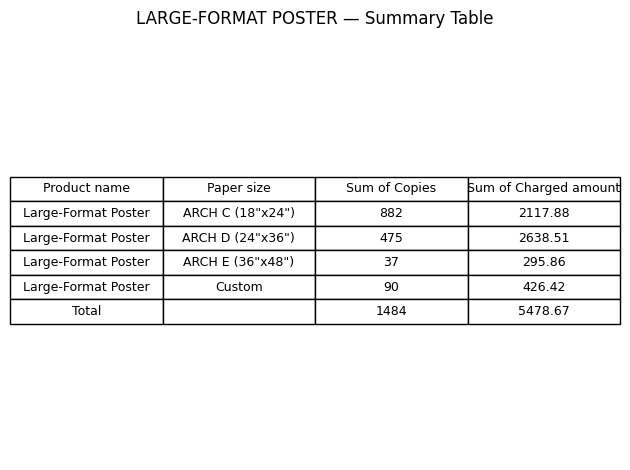

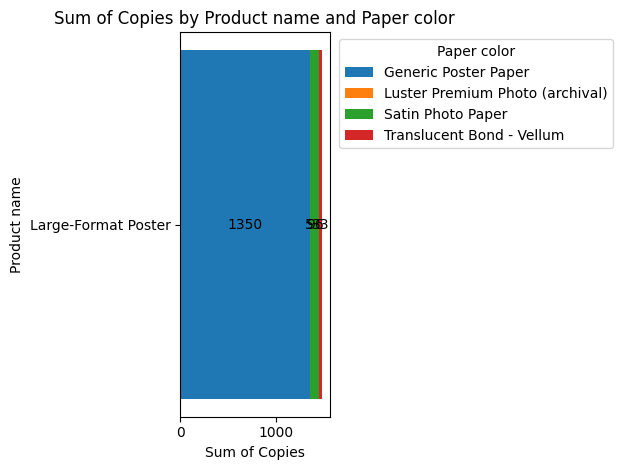

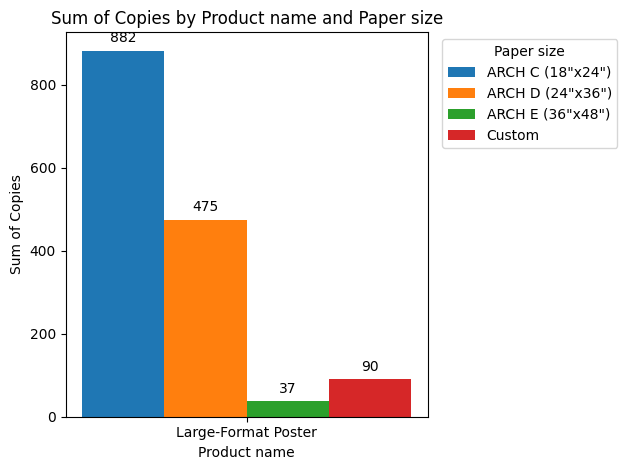

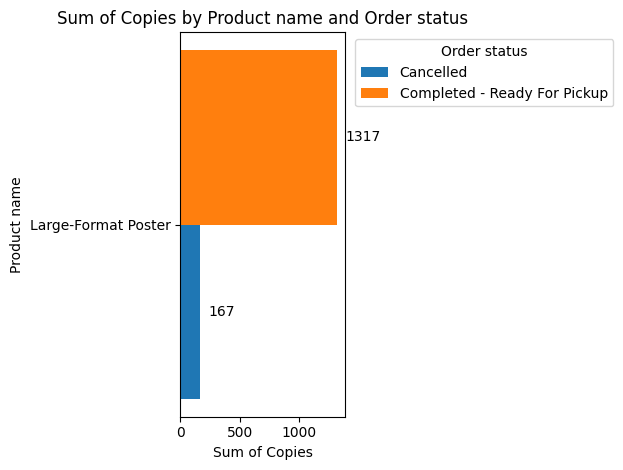

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

CSV_PATH = "orders (1).csv"          # change if needed
PRODUCT = "Large-Format Poster"

# ---------- helpers ----------
def clean_currency(series: pd.Series) -> pd.Series:
    """'$2,117.88' -> 2117.88"""
    s = (series.astype(str)
         .str.replace("$", "", regex=False)
         .str.replace(",", "", regex=False)
         .str.strip())
    return pd.to_numeric(s, errors="coerce")

def label_vertical(ax):
    for r in ax.patches:
        h = r.get_height()
        if h == 0:
            continue
        ax.annotate(f"{int(h)}",
                    (r.get_x() + r.get_width()/2, h),
                    ha="center", va="bottom",
                    xytext=(0, 4), textcoords="offset points")

def label_horizontal(ax):
    for r in ax.patches:
        w = r.get_width()
        if w == 0:
            continue
        ax.annotate(f"{int(w)}",
                    (w, r.get_y() + r.get_height()/2),
                    ha="left", va="center",
                    xytext=(6, 0), textcoords="offset points")

# ---------- load + clean ----------
df = pd.read_csv(CSV_PATH)

# needed columns
need = ["Product name", "Paper size", "Paper color", "Order status", "Copies", "Charged amount"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

df["Copies"] = pd.to_numeric(df["Copies"], errors="coerce").fillna(0)
df["Charged amount"] = clean_currency(df["Charged amount"]).fillna(0)

# filter product
lfp = df[df["Product name"].astype(str).str.strip() == PRODUCT].copy()

# sanity check (matches your PBI screenshot)
print("TOTAL Copies:", int(lfp["Copies"].sum()))
print("TOTAL Charged amount:", round(lfp["Charged amount"].sum(), 2))

# =========================================================
# 1) TABLE: Product name + Paper size + Sum Copies + Sum Charged amount
# =========================================================
table_df = (
    lfp.groupby(["Product name", "Paper size"], dropna=False)
       .agg(**{
           "Sum of Copies": ("Copies", "sum"),
           "Sum of Charged amount": ("Charged amount", "sum")
       })
       .reset_index()
)

# order like your screenshot
paper_size_order = ['ARCH C (18"x24")', 'ARCH D (24"x36")', 'ARCH E (36"x48")', 'Custom']
table_df["Paper size"] = pd.Categorical(table_df["Paper size"], categories=paper_size_order, ordered=True)
table_df = table_df.sort_values("Paper size")

# add Total row
total_row = pd.DataFrame([{
    "Product name": "Total",
    "Paper size": "",
    "Sum of Copies": table_df["Sum of Copies"].sum(),
    "Sum of Charged amount": table_df["Sum of Charged amount"].sum()
}])
table_show = pd.concat([table_df, total_row], ignore_index=True)

print("\n=== TABLE (replica) ===")
print(table_show)

# optional: render table as a figure
fig, ax = plt.subplots()
ax.axis("off")
ax.set_title("LARGE-FORMAT POSTER — Summary Table", pad=12)
t = ax.table(cellText=table_show.values, colLabels=table_show.columns, cellLoc="center", loc="center")
t.auto_set_font_size(False)
t.set_fontsize(9)
t.scale(1, 1.3)
plt.tight_layout()
plt.show()

# =========================================================
# 2) STACKED HORIZONTAL: Sum of Copies by Product name and Paper color
# =========================================================
paper_color_sum = lfp.groupby("Paper color")["Copies"].sum()

paper_color_order = [
    "Generic Poster Paper",
    "Luster Premium Photo (archival)",
    "Satin Photo Paper",
    "Translucent Bond - Vellum",
]
# keep any extra colors not in the preferred list
extra_colors = [c for c in paper_color_sum.index if c not in paper_color_order]
paper_color_order = [c for c in paper_color_order if c in paper_color_sum.index] + sorted(extra_colors)

vals = [paper_color_sum.get(c, 0) for c in paper_color_order]

fig, ax = plt.subplots()
left = 0
y = 0
for c, v in zip(paper_color_order, vals):
    ax.barh(y, v, left=left, label=c)
    if v > 0:
        ax.text(left + v/2, y, f"{int(v)}", ha="center", va="center")
    left += v

ax.set_yticks([y])
ax.set_yticklabels([PRODUCT])
ax.set_title("Sum of Copies by Product name and Paper color")
ax.set_xlabel("Sum of Copies")
ax.set_ylabel("Product name")
ax.legend(title="Paper color", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# =========================================================
# 3) CLUSTERED COLUMNS: Sum of Copies by Product name and Paper size
# =========================================================
paper_size_sum = lfp.groupby("Paper size")["Copies"].sum()
sizes = [s for s in paper_size_order if s in paper_size_sum.index]
vals = [paper_size_sum[s] for s in sizes]

x = np.array([0])  # single product group
n = len(sizes)
width = 0.18 if n <= 4 else 0.12

fig, ax = plt.subplots()
for i, (s, v) in enumerate(zip(sizes, vals)):
    xpos = x + (i - (n - 1) / 2) * width
    ax.bar(xpos, v, width=width, label=s)

# label each bar
label_vertical(ax)

ax.set_xticks(x)
ax.set_xticklabels([PRODUCT])
ax.set_title("Sum of Copies by Product name and Paper size")
ax.set_xlabel("Product name")
ax.set_ylabel("Sum of Copies")
ax.legend(title="Paper size", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# =========================================================
# 4) CLUSTERED HORIZONTAL: Sum of Copies by Product name and Order status
# =========================================================
status_sum = lfp.groupby("Order status")["Copies"].sum()
status_order = ["Cancelled", "Completed - Ready For Pickup"]
extra_status = [s for s in status_sum.index if s not in status_order]
status_order = [s for s in status_order if s in status_sum.index] + sorted(extra_status)

vals = [status_sum[s] for s in status_order]

fig, ax = plt.subplots()
y0 = 0
bar_h = 0.35
offsets = np.linspace(-bar_h/2, bar_h/2, num=len(status_order))

for off, s, v in zip(offsets, status_order, vals):
    ax.barh(y0 + off, v, height=bar_h/len(status_order) * 2, label=s)

# add labels for grouped bars
label_horizontal(ax)

ax.set_yticks([y0])
ax.set_yticklabels([PRODUCT])
ax.set_title("Sum of Copies by Product name and Order status")
ax.set_xlabel("Sum of Copies")
ax.set_ylabel("Product name")
ax.legend(title="Order status", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()
